Import basic libraries and download data

In [15]:
import pandas as pd
import numpy as np
from sklearn import model_selection

In [2]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
train_df.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829


### Null check in the data and Handle null values
** Data don't have any null values

In [3]:
train_df.isnull().sum()

Item_ID                 0
Item_W                  0
Item_Type               0
Item_MRP                0
Outlet_ID               0
Outlet_Year             0
Outlet_Size             0
Outlet_Location_Type    0
Sales                   0
dtype: int64

### EDA for the train data

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87864 entries, 0 to 87863
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_ID               87864 non-null  object 
 1   Item_W                87864 non-null  float64
 2   Item_Type             87864 non-null  object 
 3   Item_MRP              87864 non-null  float64
 4   Outlet_ID             87864 non-null  object 
 5   Outlet_Year           87864 non-null  int64  
 6   Outlet_Size           87864 non-null  object 
 7   Outlet_Location_Type  87864 non-null  object 
 8   Sales                 87864 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 6.0+ MB


In [5]:
#get all the columns with catagorical values
cat_columns = list(train_df.select_dtypes(['object']).columns)

#get all the columns with numerical values
num_columns = list(train_df.select_dtypes(['int64', 'float64']).columns)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc23dfbb310>,
      dtype=object)

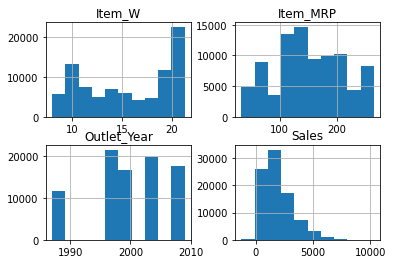

In [6]:
train_df.hist()

### Handling categorical variables
** check the unique values in all the variable

** Use Lebel encoding

** Use one hot encoding

In [7]:
[(col, len(train_df[col].unique()), ("Many" if len(train_df[col].unique()) > 20 else train_df[col].unique())) for col in cat_columns]

[('Item_ID', 895, 'Many'),
 ('Item_Type',
  16,
  array(['Baking Goods', 'Meat', 'Hard Drinks', 'Starchy Foods', 'Breads',
         'Others', 'Seafood', 'Fruits and Vegetables', 'Soft Drinks',
         'Household', 'Snack Foods', 'Frozen Foods', 'Health and Hygiene',
         'Canned', 'Dairy', 'Breakfast'], dtype=object)),
 ('Outlet_ID',
  5,
  array(['OUT046', 'OUT035', 'OUT049', 'OUT018', 'OUT013'], dtype=object)),
 ('Outlet_Size', 3, array(['Small', 'Medium', 'High'], dtype=object)),
 ('Outlet_Location_Type',
  3,
  array(['Tier 2', 'Tier 1', 'Tier 3'], dtype=object))]

In [8]:
# Importing library for pre processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [9]:
#concatting train and test data for processing
test_df.loc[:, "Sales"] = -1

data = pd.concat([train_df, test_df]).reset_index(drop=True)


In [10]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# We are doing lebel encoding for Outlet_ID, Outlet_Size and Outlet_Location_Type
lebel_encode_col = ['Outlet_ID', 'Outlet_Size', 'Outlet_Location_Type']
oh_encode_col = ['Item_Type']

# Assigning numerical values and storing in another column
data[lebel_encode_col] = data[lebel_encode_col].apply(labelencoder.fit_transform)

# implementing one hot encoding on Item_Type col
oh_train_data = pd.get_dummies(data[oh_encode_col])
data = data.drop(oh_encode_col, axis=1)
data = pd.concat([data, oh_train_data], axis=1)

data.head()

,Item_ID,Item_W,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,FDU32,21.027499,197.352319,3,2004,2,1,2689.457781,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NCT54,21.102371,148.250214,2,1987,2,0,3437.350375,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,FDW08,20.882263,205.465010,2,1999,2,2,3129.967268,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,FDJ22,21.050435,253.417583,3,1996,2,0,1306.514376,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,FDF47,21.247876,240.871039,2,1988,2,2,1739.769829,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
data_without_itemid = data.drop("Item_ID", axis=1)
data_without_itemid.head()

,Item_W,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,21.027499,197.352319,3,2004,2,1,2689.457781,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,21.102371,148.250214,2,1987,2,0,3437.350375,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,20.882263,205.465010,2,1999,2,2,3129.967268,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,21.050435,253.417583,3,1996,2,0,1306.514376,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,21.247876,240.871039,2,1988,2,2,1739.769829,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
training_data = data_without_itemid[data_without_itemid["Sales"] != -1].reset_index(drop=True)
testing_data = data_without_itemid[data_without_itemid["Sales"] == -1].reset_index(drop=True)


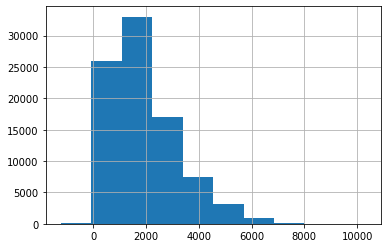

In [13]:
training_data['Sales'].hist()

### create K fold of the data

In [17]:
training_data['kfold'] = -1

In [18]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(training_data)):
  training_data.loc[valid_indices, 'kfold'] = fold

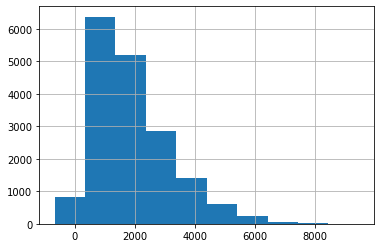

In [24]:
training_data[training_data['kfold']==4]['Sales'].hist()

In [25]:
training_data.to_csv("train_fold.csv", index=False)

In [26]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [27]:
kf_train_df = pd.read_csv("train_fold.csv")

useful_cols = [col for col in kf_train_df.columns if col not in ['kfold', 'Sales']]
final_prediction = []

for fold in range(5):
  kf_train_data = kf_train_df[kf_train_df['kfold'] != fold]
  kf_val_data = kf_train_df[kf_train_df['kfold'] == fold]
  
  xTrain = kf_train_data[useful_cols]
  xVal = kf_val_data[useful_cols]

  yTrain = kf_train_data['Sales']
  yVal = kf_val_data['Sales']

  xTest = testing_data[useful_cols]

  model = XGBRegressor(n_estimators=100, max_depth = 3, min_child_weight = 1, learning_rate=0.1, n_jobs=-1)
  model.fit(xTrain, yTrain)

  pred_val = model.predict(xVal)

  pred_test = model.predict(xTest)

  final_prediction.append(pred_test)
  print(fold, mean_absolute_error(pred_val, yVal))


[17:08:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0 1003.4513182398842
[17:09:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 1001.2807793567787
[17:09:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2 1005.796909331192
[17:09:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3 996.6930826713815
[17:09:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4 997.59395711841


In [28]:
final_prediction

[array([2140.4438, 2115.54  , 1773.4543, ..., 1815.7211, 1656.9843,
        1656.9843], dtype=float32),
 array([2041.1996, 2055.6362, 1809.3326, ..., 1786.1356, 1393.0829,
        1363.8129], dtype=float32),
 array([2097.0537, 1846.6501, 1831.0726, ..., 1727.9736, 1330.5072,
        1330.5072], dtype=float32),
 array([2067.5002, 1974.9321, 1786.3186, ..., 1744.1854, 1317.1426,
        1317.1426], dtype=float32),
 array([2090.9543, 1867.1989, 1779.7393, ..., 1704.1641, 1391.1101,
        1391.1101], dtype=float32)]

In [31]:
np.mean(np.column_stack(final_prediction), axis=1)

array([2087.4302, 1971.9915, 1795.9836, ..., 1755.636 , 1417.7654,
       1411.9114], dtype=float32)

In [32]:
submission = pd.read_csv("/content/submission.csv")
submission["Sales"] = np.mean(np.column_stack(final_prediction), axis=1)

submission.to_csv('/content/submission.csv', index=False, header=submission.columns)

## Below this is not in use now

### Separate target data from the independent variable


In [ ]:
Y_data = training_data['Sales']
X_data = training_data.drop('Sales', axis=1)

X_data.head()

,Item_W,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,21.027499,197.352319,3,2004,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,21.102371,148.250214,2,1987,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,20.882263,205.465010,2,1999,2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,21.050435,253.417583,3,1996,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,21.247876,240.871039,2,1988,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# From here We have to re write the code

In [ ]:
one_hot_cat_col = ['Outlet_Size', 'Outlet_Location_Type', 'Item_Type', 'Outlet_ID']
lebel_encoding_col = ['Item_ID']

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train = X_data.copy()
X_test = test_df.copy()

oh_train_data = pd.get_dummies(X_train[one_hot_cat_col])
X_train = X_train.drop(one_hot_cat_col, axis=1)
X_train_oh = pd.concat([X_train, oh_train_data], axis=1)


oh_test_data = pd.get_dummies(X_test[one_hot_cat_col])
X_test = X_test.drop(one_hot_cat_col, axis=1)
X_test_oh = pd.concat([X_test, oh_test_data], axis=1)



In [ ]:
X_train_oh = X_train_oh.drop(lebel_encoding_col, axis=1)

In [ ]:
X_train_oh.corr()


,Item_W,Item_MRP,Outlet_Year,Sales,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_ID_OUT013,Outlet_ID_OUT018,Outlet_ID_OUT035,Outlet_ID_OUT046,Outlet_ID_OUT049
Item_W,1.000000,-0.022830,0.009632,0.000615,0.050107,0.044235,-0.076202,-0.023464,-0.016754,0.040354,-0.055144,-0.014977,0.020477,0.031546,0.047465,0.048231,-0.025394,-0.030367,0.028458,0.041803,-0.049110,-0.030387,-0.010521,0.063396,-0.004555,-0.013323,0.023144,0.024908,-0.020942,-0.019663,-0.000654
Item_MRP,-0.022830,1.000000,-0.009837,0.014813,0.005322,-0.022069,0.016665,0.016004,0.014115,-0.030110,-0.004064,-0.013852,0.008061,0.008295,0.014775,0.014624,-0.026728,0.000842,0.009676,0.014916,0.002421,-0.008983,0.000023,0.014480,-0.007873,-0.009251,0.004961,-0.036556,0.009373,0.010647,0.011286
Outlet_Year,0.009632,-0.009837,1.000000,-0.035701,-0.069891,0.220693,-0.154915,-0.125547,-0.073802,0.200677,-0.021800,-0.006010,-0.004461,-0.003891,0.004091,-0.014031,0.078872,-0.020775,-0.022526,-0.022226,-0.021825,-0.008648,0.004910,0.005479,0.015106,-0.001482,-0.060367,0.260046,-0.076670,-0.068651,-0.051926
Sales,0.000615,0.014813,-0.035701,1.000000,0.041344,-0.073045,0.038450,0.018089,0.046167,-0.063099,0.018675,0.017792,0.007631,0.001657,-0.018825,0.005906,-0.038324,0.009491,-0.007548,-0.003874,0.004886,-0.003419,0.008065,-0.002597,0.021840,-0.002209,0.046397,-0.096650,0.042481,-0.005274,0.015151
Outlet_Size_High,0.050107,0.005322,-0.069891,0.041344,1.000000,-0.269796,-0.454661,-0.066505,-0.039715,0.106900,0.004128,0.050323,0.006089,-0.041734,-0.012056,0.041238,-0.044465,0.001134,-0.005620,0.008914,0.005014,0.038828,0.016517,-0.032206,0.011268,0.002811,0.296715,-0.081418,-0.053489,-0.066719,-0.052632
Outlet_Size_Medium,0.044235,-0.022069,0.220693,-0.073045,-0.269796,1.000000,-0.734970,-0.264816,-0.232538,0.497235,-0.082423,-0.004883,-0.013259,-0.016764,0.007278,-0.072271,0.191257,-0.021800,-0.034992,-0.051891,-0.043254,-0.005306,0.026810,-0.022856,0.060957,0.040353,-0.034734,0.525282,-0.217706,-0.216990,-0.018683
Outlet_Size_Small,-0.076202,0.016665,-0.154915,0.038450,-0.454661,-0.734970,1.000000,0.291779,0.243057,-0.535205,0.073331,-0.030922,0.007976,0.044896,0.001758,0.037807,-0.145594,0.019365,0.036324,0.041720,0.036477,-0.022435,-0.036430,0.043821,-0.064319,-0.039304,-0.176822,-0.428532,0.239038,0.247692,0.054345
Outlet_Location_Type_Tier 1,-0.023464,0.016004,-0.125547,0.018089,-0.066505,-0.264816,0.291779,1.000000,-0.499344,-0.552502,-0.014002,0.000532,-0.002859,0.049607,-0.036862,-0.068383,-0.084441,0.035595,0.057292,0.031893,0.056351,0.016127,-0.008172,0.051969,-0.020142,-0.025150,-0.105187,-0.293576,0.203050,0.098424,0.057384
Outlet_Location_Type_Tier 2,-0.016754,0.014115,-0.073802,0.046167,-0.039715,-0.232538,0.243057,-0.499344,1.000000,-0.446269,0.094879,-0.017919,0.004126,-0.021646,0.026660,0.108112,-0.076108,0.018007,-0.014663,-0.011712,-0.012322,-0.029468,-0.009056,-0.027533,-0.023554,-0.021105,-0.035344,-0.235426,0.040530,0.161235,0.052840
Outlet_Location_Type_Tier 3,0.040354,-0.030110,0.200677,-0.063099,0.106900,0.497235,-0.535205,-0.552502,-0.446269,1.000000,-0.076815,0.016690,-0.001017,-0.030414,0.012427,-0.033376,0.160438,-0.054089,-0.045070,-0.021675,-0.046350,0.011692,0.017153,-0.027191,0.043465,0.046281,0.142649,0.529720,-0.248719,-0.256774,-0.110105


In [ ]:
Y_train_data = X_train_oh['Sales']
X_train_data = X_train_oh.drop(['Sales'], axis=1)

In [ ]:
Y_train_data.mean()

1911.8421198059802

In [ ]:
X_train_data.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3


In [ ]:
#Spliting train data in the training and validation set

from sklearn.model_selection import train_test_split

X_train_record, X_valid_record, y_train_record, y_valid_record = train_test_split(X_data, Y_data, test_size=0.20, random_state=42)
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, max_depth = 3, min_child_weight = 1, learning_rate=0.1)
model.fit(X_train_record, y_train_record)

[09:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

predicted_val = model.predict(X_valid_record)
mse = mean_absolute_error(predicted_val, y_valid_record)
print("Error ", mse)

Error  1003.4513182398842


In [ ]:
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

score = accuracy_score(predicted_val, y_valid_record)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

ValueError: ignored

In [ ]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X_train_record, y_train_record)

predicted_val = linear.predict(X_valid_record)
mse = mean_absolute_error(predicted_val, y_valid_record)
print("Error ", mse)

Error  1008.3305307985014


In [ ]:
X_test_oh = X_test_oh.drop(lebel_encoding_col, axis=1)

In [ ]:
submission = pd.read_csv("/content/submission.csv")

In [ ]:
testing_data = testing_data.drop("Sales", axis=1)

In [ ]:
final_predict = model.predict(testing_data)
submission["Sales"] = final_predict

submission.to_csv('/content/submission.csv', index=False, header=submission.columns)
submission.head()

,Sales
0,2140.443848
1,2115.540039
2,1773.454346
3,1806.232300
4,1507.754028
